# PCA-based EEG Artifact Removal

In this assignment, we'll generate synthetic multi-channel EEG data that includes alpha waves, blink artifacts, and muscle noise. You'll apply PCA (via SVD) to isolate and remove a blink-related component. Then you'll compare signals before and after cleaning using PSD and spectrogram analysis.

**Objectives**:
1. Generate realistic EEG-like data with random alpha activity, global blinks, and localized muscle artifacts.
2. Perform PCA (through SVD).
3. Detect the blink component more intelligently than simply removing the top PC.
4. Reconstruct signals without that component and observe improvements.
5. Estimate alpha peak frequency and amplitude before and after cleaning.

We split this assignment into several parts, each with tasks for partial credit.
Let's begin!

## Part 1: Setup and Imports

**Task**: Import the necessary libraries (NumPy, Matplotlib, `scipy.signal`) and set up basic parameters.
We'll define sampling rate, duration, number of channels, and so forth. We'll also create a directory for saving any plots if needed.

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, spectrogram


np.random.seed(42) 
fs = 256
duration = 10.0  
n_samples = int(fs * duration)
t = np.linspace(0, duration, n_samples)
n_channels = 8

os.makedirs('Figures', exist_ok=True)



## Part 2: Generate Synthetic EEG Data

Here, you'll simulate alpha waves plus blink and muscle artifacts.
1. Each channel has a random alpha frequency (8-12 Hz), amplitude (10-30), and random phase.
2. We add random noise.
3. Insert global blink artifacts (e.g., short triangular pulses).
4. Insert localized muscle artifacts in some channels.

Recall that after performing SVD (`centered_data = U Σ V^T`), each *column* of `U` is a “spatial pattern” for a principal component (PC). Because our rows are EEG channels arranged from front to back on the scalp, a PC that has **large values** in the front channels (e.g., channels 1–2) and **smaller values** in the rear channels (e.g., channels 7–8) probably corresponds to a **blink** (frontal) artifact. Thus, to detect the blink component, we compare the **average loading** in the front channels vs. the back channels for each PC. If a PC shows a big difference there, and also has a large singular value, we suspect it’s the blink component.

**Tips**:
- Define a function or do it inline.
- Keep track of the final data shape = (n_channels, n_samples).
- You may want to store blink times for reference.

In [ ]:


num_blinks = 3           
blink_width = 0.3        
blink_amp_base = 50      
channel_scaling = np.array([1.0, 1.0, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3])

num_muscle = 2          
burst_duration = 0.5     
muscle_amp_base = 20     
# Create a data array of zeros, shape (n_channels, n_samples).
data = np.zeros((n_channels, n_samples))

alpha_f_min, alpha_f_max = 8.0, 12.0  
noise_level = 5.0                     
# For each channel, generate an alpha wave with random frequency, amplitude, and phase, then add noise.
for ch in range(n_channels):
    f_alpha = np.random.uniform(alpha_f_min, alpha_f_max)
    alpha_amp = np.random.uniform(10.0, 30.0)
    alpha_phase = np.random.uniform(0, 2*np.pi)
    alpha_wave = alpha_amp * np.sin(2*np.pi*f_alpha * t + alpha_phase)
    noise = np.random.normal(0, noise_level, n_samples)
    data[ch] = alpha_wave + noise

# Insert global blink artifacts at random times.
blink_times = np.sort(np.random.uniform(1.0, duration - 1.0, num_blinks))
for bt in blink_times:
    center_idx = int(bt * fs)
    half_w = int(blink_width * fs / 2)
    for i in range(center_idx - half_w, center_idx + half_w):
        if 0 <= i < n_samples:
            dist = abs(i - center_idx)
            # Create a triangular shape for the blink artifact
            shape_amp = max(0.0, 1.0 - dist / half_w)
            for ch in range(n_channels):
                data[ch, i] += blink_amp_base * channel_scaling[ch] * shape_amp

# Insert localized muscle bursts in a few channels.
chosen_channels = np.random.choice(n_channels, size=num_muscle, replace=False)
for ch in chosen_channels:
    burst_time = np.random.uniform(1.0, duration - 1.0)
    burst_start = int(burst_time * fs)
    burst_len = int(burst_duration * fs)

    muscle_freq = np.random.uniform(20, 50)  
    muscle_phase = np.random.uniform(0, 2*np.pi)
    for i in range(burst_len):
        idx = burst_start + i
        if 0 <= idx < n_samples:
            data[ch, idx] += muscle_amp_base * np.sin(2*np.pi*muscle_freq * t[idx] + muscle_phase)

print(f'Generated data shape: {data.shape}')


Generated data shape: (8, 2560)


## Part 3: Inspect Raw Signals

Plot the raw signals in a single figure, offsetting each channel so we can see them distinctly.
**Task**:
- Make a time-domain plot of all channels.
- Label axes, title.

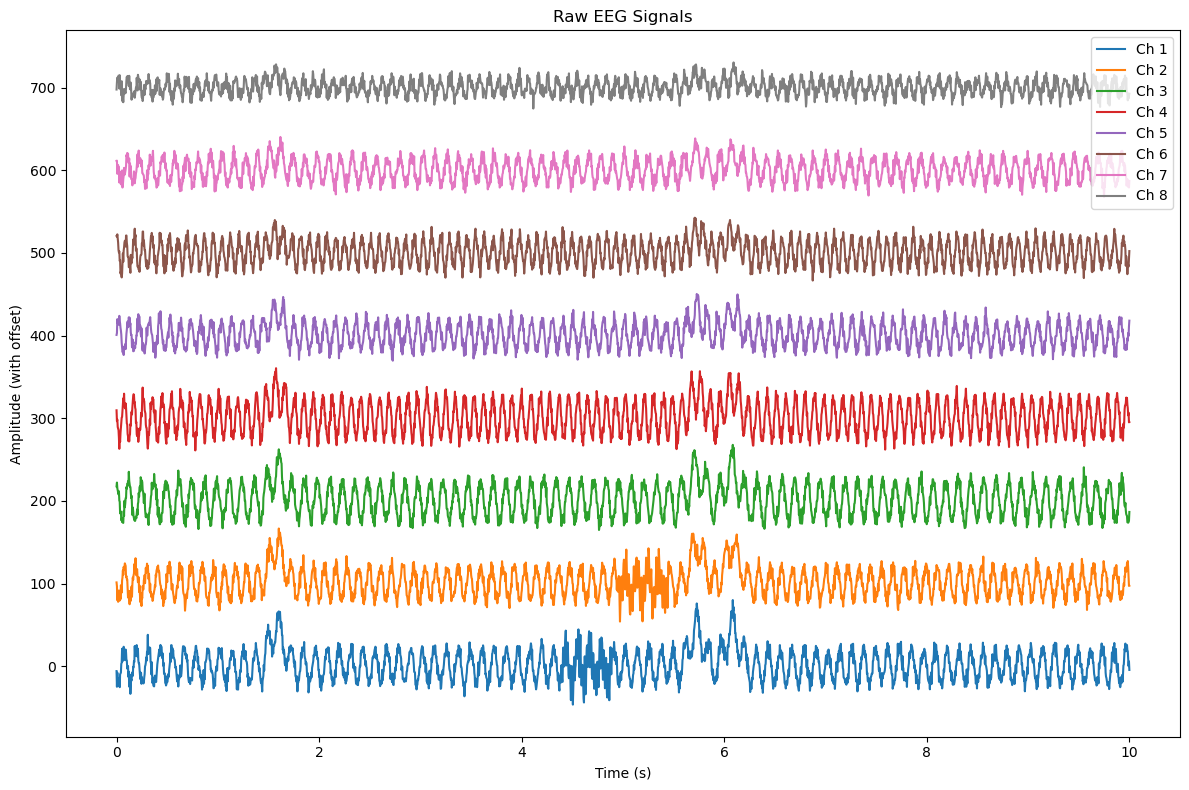

In [11]:
# Define an offset to separate the channel traces visually
offset = 100

plt.figure(figsize=(12, 8))
for ch in range(n_channels):
    plt.plot(t, data[ch] + ch*offset, label=f'Ch {ch+1}')

plt.xlabel('Time (s)')
plt.ylabel('Amplitude (with offset)')
plt.title('Raw EEG Signals')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


## Part 4: SVD-based PCA

We'll center the data, do an SVD, and interpret the singular values. Then we'll define a function to get principal components in the time domain.
**Tasks**:
1. Subtract each channel's mean.
2. Apply `np.linalg.svd`.
3. Plot singular values.
4. Write a function to produce PC time series = S diag * Vt.

Singular values: [1188.39538309  934.78427237  910.60715664  799.94978896  726.56456813
  710.4713704   558.77453615  457.23952305]


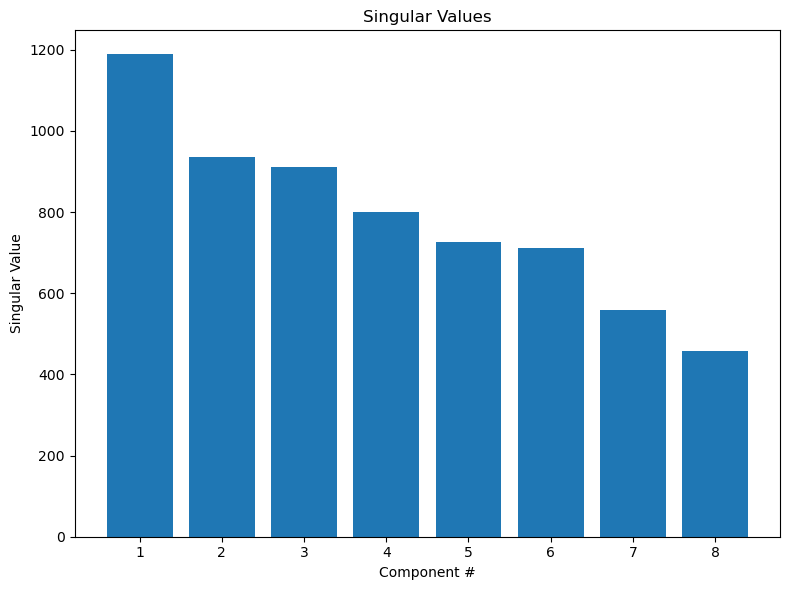

PC time series shape: (8, 2560)


In [ ]:
# Center the data by subtracting each channel's mean
data_centered = data - np.mean(data, axis=1, keepdims=True)

U, S, Vt = np.linalg.svd(data_centered, full_matrices=False)

print('Singular values:', S)

# Plot the singular values
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(S) + 1), S)
plt.title('Singular Values')
plt.xlabel('Component #')
plt.ylabel('Singular Value')
plt.tight_layout()
plt.show()

# Define a function to compute the PC time series
def get_pc_time_series(U, S, Vt):
    return np.diag(S) @ Vt

# Compute the PC time series
pc_time = get_pc_time_series(U, S, Vt)
print(f'PC time series shape: {pc_time.shape}')


## Part 5: Detect & Remove Blink Component

**Tasks**:
1. Write a function to identify the blink PC by looking at the top 3 singular values and the ratio of front vs. back channels in U.
2. Set that singular value to 0, reconstruct the data.
3. Plot the cleaned signals in time.

Detected blink component: 0


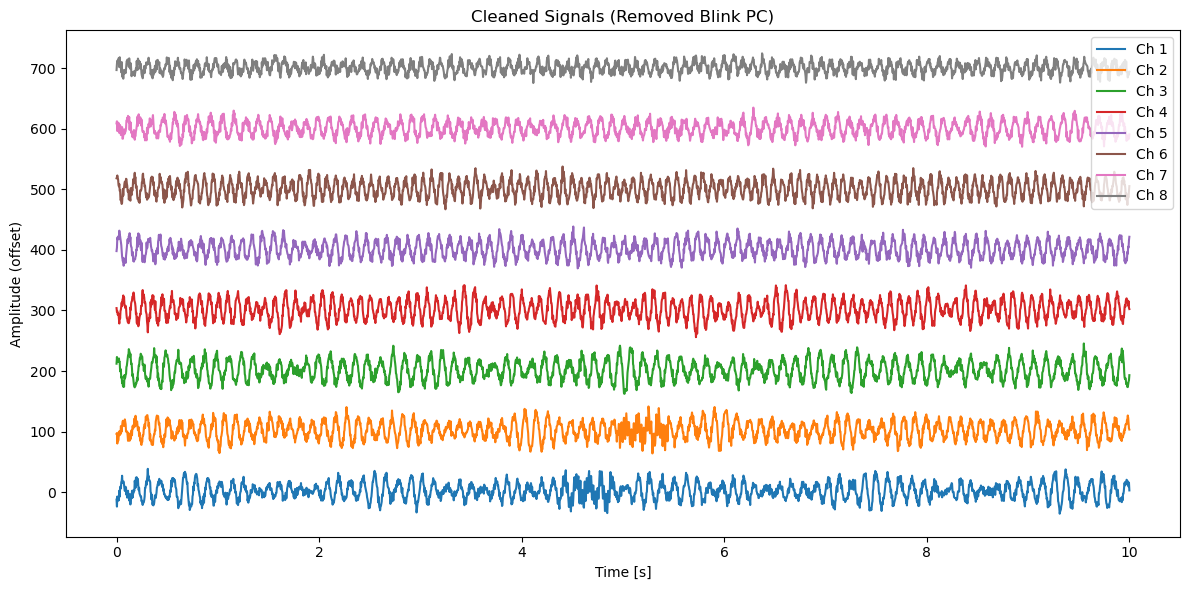

In [ ]:
def detect_blink_component(U, S):
    ratios = []
    # Consider only the top 3 components
    for i in range(min(3, U.shape[1])):
        # Compute average absolute loading for frontal channels (channels 1 and 2)
        front_mean = np.mean(np.abs(U[:2, i]))
        # Compute average absolute loading for posterior channels (channels 7 and 8)
        back_mean = np.mean(np.abs(U[-2:, i]))
        ratio = front_mean / (back_mean + 1e-6)  
        ratios.append(ratio)
    blink_idx = np.argmax(ratios)
    return blink_idx

# Detect blink component index
blink_comp_idx = detect_blink_component(U, S)
print(f'Detected blink component: {blink_comp_idx}')

# Function to reconstruct the data after removing specified components
def reconstruct_data(U, S, Vt, remove_list):
    S_mod = S.copy()
    for idx in remove_list:
        S_mod[idx] = 0  
    # Reconstruct the data: U * diag(S_mod) * Vt
    return U @ np.diag(S_mod) @ Vt

# Save the channel means for later reconstruction (from the original data)
mean_vals = np.mean(data, axis=1, keepdims=True)

# Reconstruct the centered (cleaned) data after removing the blink component
clean_centered = reconstruct_data(U, S, Vt, [blink_comp_idx])
# Add the channel means back to obtain the full reconstructed signals
clean_data = clean_centered + mean_vals

# Plot the cleaned signals with offsets
offset = 100  
plt.figure(figsize=(12, 6))
for ch in range(n_channels):
    plt.plot(t, clean_data[ch] + ch * offset, label=f'Ch {ch+1}')
plt.title('Cleaned Signals (Removed Blink PC)')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude (offset)')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


## Part 6: PSD & Spectrogram + Alpha Wave Parameter

**Tasks**:
1. Compute & plot PSD (via `welch`) for raw vs. cleaned signals.
2. Compute & plot spectrogram on at least one channel.
3. Estimate alpha frequency/amplitude (peak in 8-12 Hz) before & after cleaning,
   and print the results.

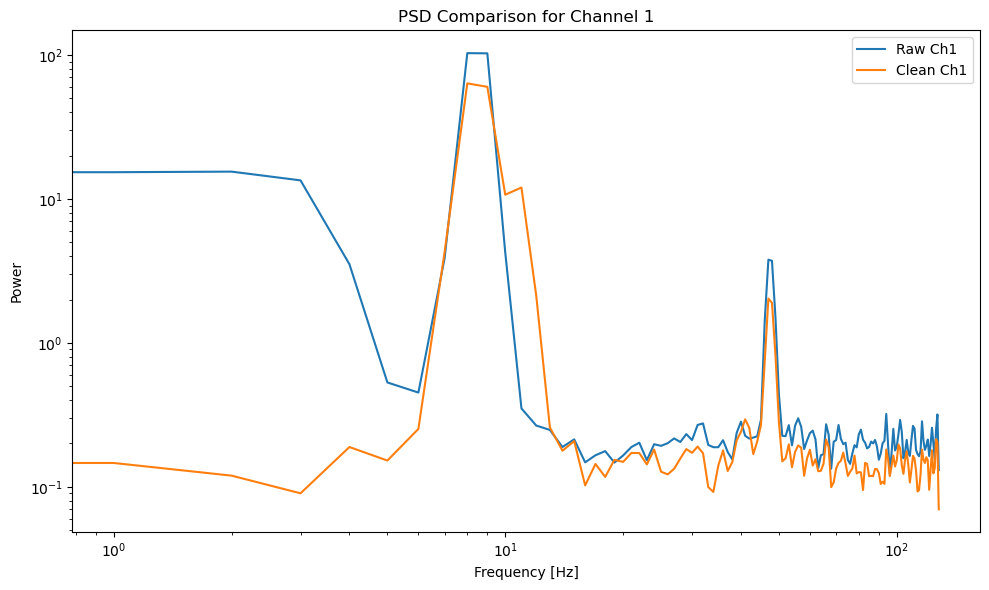

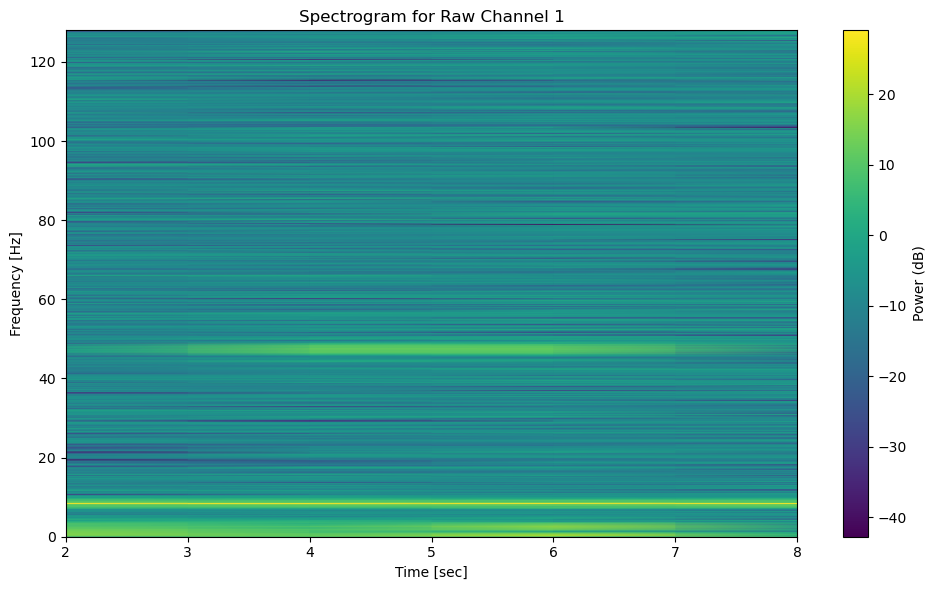

Alpha peak frequency and amplitude (Raw vs. Clean):
Channel 1:
  Raw   - Alpha peak frequency: 8.00 Hz, Amplitude: 1.03e+02
  Clean - Alpha peak frequency: 8.00 Hz, Amplitude: 6.37e+01
Channel 2:
  Raw   - Alpha peak frequency: 9.00 Hz, Amplitude: 1.28e+02
  Clean - Alpha peak frequency: 9.00 Hz, Amplitude: 9.86e+01
Channel 3:
  Raw   - Alpha peak frequency: 8.00 Hz, Amplitude: 1.99e+02
  Clean - Alpha peak frequency: 8.00 Hz, Amplitude: 1.38e+02
Channel 4:
  Raw   - Alpha peak frequency: 11.00 Hz, Amplitude: 1.94e+02
  Clean - Alpha peak frequency: 11.00 Hz, Amplitude: 1.20e+02
Channel 5:
  Raw   - Alpha peak frequency: 10.00 Hz, Amplitude: 1.07e+02
  Clean - Alpha peak frequency: 10.00 Hz, Amplitude: 9.60e+01
Channel 6:
  Raw   - Alpha peak frequency: 12.00 Hz, Amplitude: 9.40e+01
  Clean - Alpha peak frequency: 12.00 Hz, Amplitude: 8.68e+01
Channel 7:
  Raw   - Alpha peak frequency: 9.00 Hz, Amplitude: 7.46e+01
  Clean - Alpha peak frequency: 9.00 Hz, Amplitude: 6.23e+01
Channel 8:


In [ ]:
from scipy.signal import welch, spectrogram

# Compute and Plot PSD Comparison for Channel 1

# Compute PSD for channel 1 (index 0) for raw and cleaned signals.
f_raw, p_raw = welch(data[0], fs=fs, nperseg=fs)
f_cln, p_cln = welch(clean_data[0], fs=fs, nperseg=fs)

plt.figure(figsize=(10, 6))
plt.plot(f_raw, p_raw, label='Raw Ch1')
plt.plot(f_cln, p_cln, label='Clean Ch1')
plt.xscale('log')
plt.yscale('log')
plt.title('PSD Comparison for Channel 1')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power')
plt.legend()
plt.tight_layout()
plt.show()

# Compute and Plot a Spectrogram for Channel 1

# Compute spectrogram for raw data on channel 1 (index 0)
f_sp, t_sp, Sxx_raw = spectrogram(data[0], fs=fs, nperseg=1024, noverlap=512)
plt.figure(figsize=(10, 6))
plt.pcolormesh(t_sp, f_sp, 10 * np.log10(Sxx_raw), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Spectrogram for Raw Channel 1')
plt.colorbar(label='Power (dB)')
plt.tight_layout()
plt.show()

# Define a Function to Estimate Alpha Peak Frequency & Amplitude 
def find_alpha_peak(frequencies, power, f_low=8, f_high=12):
    idx = (frequencies >= f_low) & (frequencies <= f_high)
    if not np.any(idx):
        return None, None  
    f_range = frequencies[idx]
    p_range = power[idx]
    peak_idx = np.argmax(p_range)
    return f_range[peak_idx], p_range[peak_idx]

#  Compute & Print Alpha Peak Parameters for Each Channel 
print("Alpha peak frequency and amplitude (Raw vs. Clean):")
for ch in range(n_channels):
    # Compute PSD for raw and cleaned signals for this channel
    f_raw, p_raw = welch(data[ch], fs=fs, nperseg=fs)
    f_cln, p_cln = welch(clean_data[ch], fs=fs, nperseg=fs)
    
    # Find the alpha peak for raw and clean data
    alpha_freq_raw, alpha_amp_raw = find_alpha_peak(f_raw, p_raw)
    alpha_freq_cln, alpha_amp_cln = find_alpha_peak(f_cln, p_cln)
    
    print(f"Channel {ch+1}:")
    print(f"  Raw   - Alpha peak frequency: {alpha_freq_raw:.2f} Hz, Amplitude: {alpha_amp_raw:.2e}")
    print(f"  Clean - Alpha peak frequency: {alpha_freq_cln:.2f} Hz, Amplitude: {alpha_amp_cln:.2e}")
